# <br> HDBSCAN Clustering analysis performed for hotels' data coming from Bidroom DB: PCA & UMAP for dimentionality reduction

### Information about data set:<br>
#### 1. Analysis was performed for sample about 1000 data from database. 
#### 2. Data were taken for two cities with the higest number of active hotels. <br> 


In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Importing Libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()
### libraries to reduce data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn import metrics
from sklearn.decomposition import PCA
import umap
import hdbscan
##libraries needed for clustering analysis
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from DBCV.DBCV import DBCV

pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', True)


## Importing file with data and creating its copy

#### <br> This set of characteristics was discussed and chosen as the most valuable/informative out of other available in database with Thomas <br>

In [3]:
file = pd.read_csv("Documents/clustering/dbscan/idGBdata.csv")
fileWorking = file.copy()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1040 non-null   int64  
 1   hotel_city           1040 non-null   int64  
 2   hotel_type           1040 non-null   int64  
 3   hotel_country        1040 non-null   object 
 4   hotel_currency_code  1040 non-null   object 
 5   hotel_lat            1040 non-null   float64
 6   hotel_lon            1040 non-null   float64
 7   hotel_distance       881 non-null    float64
 8   rooms_count          1040 non-null   int64  
 9   room_type_en         188 non-null    object 
 10  room_type_no         238 non-null    float64
 11  label                0 non-null      float64
 12  amenity              1038 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 105.8+ KB


#### <br> This analysis is provided for characteristics without the room_types that is why I am removing from original file thwo columns: room_type_no and room_type_en  <br>

In [4]:
fileWorking = fileWorking.drop(columns=["room_type_no","room_type_en"])

### <br>**Expectations/hypothesis behind chosen characteristics:**<br>
#### - **hotel_currency_code** will probably be highly correlated with eg Country, here is just taken to confirm that and remove from future analysis;
#### - **hotel_distnace** should be very informative and diverging characteristics because it calculates the distance from the city center;
#### - **amenities list**  amenities are chosen because, in my and Thomas opinion, to compare prices we should compare them among not only hotels with the same type but also with the same offer according to what is available for the guest to make their stay more comfortable;
#### - **rooms_count** were chosen because we should compare prices among hotels which are more or less the same size, if a guest prefers small hotels he will be comparying prices among the small ones;
#### This analysis is a first of such type for the data we are storing in our database and I didn't wanted to miss any level that cound be crucial for hotels categorization<br>

## Data Preprocessing

In [5]:
fileWorking.head()

hotel_id  hotel_city  hotel_type hotel_country hotel_currency_code  \
0      5622        1174           4            GB                 GBP   
1      5630        1174           3            GB                 GBP   
2      5640        1174           4            GB                 GBP   
3      5671        1174           4            GB                 GBP   
4      5681        1174           5            GB                 GBP   

   hotel_lat  hotel_lon  hotel_distance  rooms_count  label  \
0  51.521259  -0.155856            3.12           34    NaN   
1  51.512071  -0.185206            4.30           45    NaN   
2  51.507706  -0.147138            1.67          106    NaN   
3  51.490098  -0.138130            1.39           72    NaN   
4  51.496872  -0.167604            2.89           28    NaN   

                                             amenity  
0  Free WIFI,Elevator / Lift,Air Conditioned,Free...  
1  Free WIFI,Elevator / Lift,Free WIFI,Elevator /...  
2  Free WIFI,Elevator / Lift,Parking,Fitness Room...  
3  Free WIFI,Elevator / Lift,Air Conditioned,Free...  
4  Free WIFI,Elevator / Lift,Parking,Pet Friendly...

#### I used the one-hot-encoding for hotel_type - separate column was created for each hotel_type and as a value was 1 if the hotel was that type and 0 otherwise

In [6]:
def hotelTypeToColumns(df):
    hotelTypeDict = {
        1:"1-star_Hotel",
        2:"2-star_Hotel",
        3:"3-star_Hotel",
        4:"4-star_Hotel",
        5:"5-star_Hotel",
        8:"Apartment_Hotel_Type",
        9:"Hostel",
        10:"Motel",
        11:"Inn",
        12:"Bed&Breakfast",
        13:"Vacation_Rental",
        15:"Resort",
        16:"Other",
        23:"Aparthotel",
        25:"Boutique_Hotel",
        30:"Guesthouse",
        32:"Camping",
        33:"Villa",
        34:"Farm_Stay",
        36:"Hotel"
    }   
    keyList = list(df["hotel_type"].unique())
    newColumns = {hotelTypeDict[x]:x for x in keyList}
    for k, v in newColumns.items():
        df[k] = [1 if c == v else 0 for c in df["hotel_type"]]
    
    df.columns = df.columns.str.lower()
    return df


In [7]:
fileWorking = hotelTypeToColumns(fileWorking)

In [8]:
fileWorking = fileWorking.drop(columns=["hotel_type"])

In [9]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              1040 non-null   int64  
 1   hotel_city            1040 non-null   int64  
 2   hotel_country         1040 non-null   object 
 3   hotel_currency_code   1040 non-null   object 
 4   hotel_lat             1040 non-null   float64
 5   hotel_lon             1040 non-null   float64
 6   hotel_distance        881 non-null    float64
 7   rooms_count           1040 non-null   int64  
 8   label                 0 non-null      float64
 9   amenity               1038 non-null   object 
 10  4-star_hotel          1040 non-null   int64  
 11  3-star_hotel          1040 non-null   int64  
 12  5-star_hotel          1040 non-null   int64  
 13  2-star_hotel          1040 non-null   int64  
 14  aparthotel            1040 non-null   int64  
 15  hostel               

#### <br> Amenities column contains a list of amenities for specific hotel in one cell. That Is why I put them to separate coulmns and gave True (1) if the hotel has that and False (0) otherwise <br>

#### <br> First I removed two rows that didn't have any amenities and label column that did not have any data <br>

In [10]:
fileWorking.loc[pd.isna(fileWorking["amenity"]), :].index

Int64Index([109, 111], dtype='int64')

In [11]:
fileWorking = fileWorking.drop([fileWorking.index[109], fileWorking.index[111]])

In [12]:
fileWorking = fileWorking.drop(columns=["label"])

In [13]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1039
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              1038 non-null   int64  
 1   hotel_city            1038 non-null   int64  
 2   hotel_country         1038 non-null   object 
 3   hotel_currency_code   1038 non-null   object 
 4   hotel_lat             1038 non-null   float64
 5   hotel_lon             1038 non-null   float64
 6   hotel_distance        879 non-null    float64
 7   rooms_count           1038 non-null   int64  
 8   amenity               1038 non-null   object 
 9   4-star_hotel          1038 non-null   int64  
 10  3-star_hotel          1038 non-null   int64  
 11  5-star_hotel          1038 non-null   int64  
 12  2-star_hotel          1038 non-null   int64  
 13  aparthotel            1038 non-null   int64  
 14  hostel                1038 non-null   int64  
 15  apartment_hotel_type 

### Creating separate sets of amenities for each city

#### Creating working file for Jakarta in Indonesia

In [14]:
fileWorkingID = fileWorking.loc[fileWorking.hotel_country=="ID"]
fileWorkingID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 17 to 995
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              648 non-null    int64  
 1   hotel_city            648 non-null    int64  
 2   hotel_country         648 non-null    object 
 3   hotel_currency_code   648 non-null    object 
 4   hotel_lat             648 non-null    float64
 5   hotel_lon             648 non-null    float64
 6   hotel_distance        636 non-null    float64
 7   rooms_count           648 non-null    int64  
 8   amenity               648 non-null    object 
 9   4-star_hotel          648 non-null    int64  
 10  3-star_hotel          648 non-null    int64  
 11  5-star_hotel          648 non-null    int64  
 12  2-star_hotel          648 non-null    int64  
 13  aparthotel            648 non-null    int64  
 14  hostel                648 non-null    int64  
 15  apartment_hotel_type  

#### Creating working file for London in Great Britain

In [15]:
fileWorkingGB = fileWorking.loc[fileWorking.hotel_country=="GB"]
fileWorkingGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 1039
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              390 non-null    int64  
 1   hotel_city            390 non-null    int64  
 2   hotel_country         390 non-null    object 
 3   hotel_currency_code   390 non-null    object 
 4   hotel_lat             390 non-null    float64
 5   hotel_lon             390 non-null    float64
 6   hotel_distance        243 non-null    float64
 7   rooms_count           390 non-null    int64  
 8   amenity               390 non-null    object 
 9   4-star_hotel          390 non-null    int64  
 10  3-star_hotel          390 non-null    int64  
 11  5-star_hotel          390 non-null    int64  
 12  2-star_hotel          390 non-null    int64  
 13  aparthotel            390 non-null    int64  
 14  hostel                390 non-null    int64  
 15  apartment_hotel_type  

In [16]:
def handleAmenities(df):
    import re
    amenities =  []
    for num, x in enumerate(df["amenity"]):
        try:
            x = x.split(sep=',')
            amenities = amenities + x
        except:
            amenities.append(x)
    amenities = list(set(amenities))
    for x in amenities:
        if x != x:
            continue
        else:
            com = '(.*)?('+ x +')(.*)?'
            df[x]=[1 if re.search(com,str(a)) is not None else 0 for a in df["amenity"]]
    df = df.drop(columns=["amenity"])
    return df

amenitiesID = handleAmenities(fileWorkingID[["hotel_id","amenity"]])
amenitiesGB = handleAmenities(fileWorkingGB[["hotel_id","amenity"]])

/home/agata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### Creating final dataset for clustering analysis

In [17]:
# for Jakarta
fileWorkingID = fileWorkingID.merge(amenitiesID, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingID.columns = fileWorkingID.columns.str.lower()

# for London
fileWorkingGB = fileWorkingGB.merge(amenitiesGB, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingGB.columns = fileWorkingGB.columns.str.lower()

In [18]:
fileWorkingGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 389
Data columns (total 62 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hotel_id                    390 non-null    int64  
 1   hotel_city                  390 non-null    int64  
 2   hotel_country               390 non-null    object 
 3   hotel_currency_code         390 non-null    object 
 4   hotel_lat                   390 non-null    float64
 5   hotel_lon                   390 non-null    float64
 6   hotel_distance              243 non-null    float64
 7   rooms_count                 390 non-null    int64  
 8   4-star_hotel                390 non-null    int64  
 9   3-star_hotel                390 non-null    int64  
 10  5-star_hotel                390 non-null    int64  
 11  2-star_hotel                390 non-null    int64  
 12  aparthotel                  390 non-null    int64  
 13  hostel                      390 non

## Data Cleaning

### Removing duplicates

In [19]:
# for Jakarta
filesWorkingIDCleaned = fileWorkingID.drop_duplicates(subset=["hotel_id"], keep="first")
# for London
filesWorkingGBCleaned = fileWorkingGB.drop_duplicates(subset=["hotel_id"], keep="first")

### Handling inconsistent data

In [20]:
def mappingCategoricalData(seriesUnique):
    catData = {}
    for i, code in enumerate(seriesUnique):
        catData[code] = i+1
    return catData

#### handling information for hotel_currency_code

In [21]:
filesWorkingIDCleaned["hotel_currency_code"].isna().sum()

0

In [22]:
filesWorkingIDCleaned["hotel_currency_code"].unique()

array(['IDR', 'USD', 'EUR'], dtype=object)

In [23]:
filesWorkingGBCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 389
Data columns (total 62 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hotel_id                    390 non-null    int64  
 1   hotel_city                  390 non-null    int64  
 2   hotel_country               390 non-null    object 
 3   hotel_currency_code         390 non-null    object 
 4   hotel_lat                   390 non-null    float64
 5   hotel_lon                   390 non-null    float64
 6   hotel_distance              243 non-null    float64
 7   rooms_count                 390 non-null    int64  
 8   4-star_hotel                390 non-null    int64  
 9   3-star_hotel                390 non-null    int64  
 10  5-star_hotel                390 non-null    int64  
 11  2-star_hotel                390 non-null    int64  
 12  aparthotel                  390 non-null    int64  
 13  hostel                      390 non

In [24]:
curr1 = filesWorkingIDCleaned["hotel_currency_code"].unique()
curr2 = filesWorkingGBCleaned["hotel_currency_code"].unique()
currCode1 = mappingCategoricalData(curr1)
currCode2 = mappingCategoricalData(curr2)
# for Jakarta
filesWorkingIDCleaned["hotel_currency_code"] = filesWorkingIDCleaned["hotel_currency_code"].map(currCode1)
# # for London
filesWorkingGBCleaned["hotel_currency_code"] = filesWorkingGBCleaned["hotel_currency_code"].map(currCode2)

#### handling information for hotel_country

In [25]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["hotel_country", "hotel_city"])
filesWorkingGBCleaned = filesWorkingGBCleaned.drop(columns=["hotel_country", "hotel_city"])

#### handling information for hotel_distance 

In [26]:
filesWorkingIDCleaned["hotel_distance"].value_counts(dropna=False)

3.90     20
4.15     14
10.84    14
NaN      12
4.16      7
         ..
12.00     1
3.33      1
8.51      1
6.91      1
2.43      1
Name: hotel_distance, Length: 383, dtype: int64

In [27]:
filesWorkingGBCleaned["hotel_distance"].value_counts(dropna=False)

NaN     147
3.84      4
1.60      3
4.03      3
2.39      3
       ... 
4.15      1
1.88      1
2.68      1
3.29      1
1.32      1
Name: hotel_distance, Length: 201, dtype: int64

#### There is lack of calculated hotel distance for 147 hotels in London and 12 for Jakarta so I used mean calculated per city o fill that data

In [28]:
mean1  = filesWorkingIDCleaned["hotel_distance"].mean()
mean2  = filesWorkingGBCleaned["hotel_distance"].mean()
filesWorkingIDCleaned["hotel_distance"].fillna(mean2, inplace=True)
filesWorkingGBCleaned["hotel_distance"].fillna(mean1, inplace=True)

#### handling information for hotel_lat and hotel_lon

In [29]:
# for Jakarta
filesWorkingIDCleaned["hotel_lat"] = filesWorkingIDCleaned["hotel_lat"].apply(lambda x: round(x,5))
filesWorkingGBCleaned["hotel_lon"] = filesWorkingGBCleaned["hotel_lon"].apply(lambda x: round(x,5))
# for London
filesWorkingIDCleaned["hotel_lat"] = filesWorkingIDCleaned["hotel_lat"].apply(lambda x: round(x,5))
filesWorkingGBCleaned["hotel_lon"] = filesWorkingGBCleaned["hotel_lon"].apply(lambda x: round(x,5))

#### dropping columns that have only one value and it is 0 

In [30]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["5-star_hotel", "aparthotel", "1-star_hotel", "boutique_hotel"])

#### dropping hotel_id for all data sets

In [31]:
indonesia = filesWorkingIDCleaned.drop(columns=["hotel_id"])
gb = filesWorkingGBCleaned.drop(columns=["hotel_id"])

### Visualize heatmap for all hotels characteristics in Jakarta

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in Jakarta')

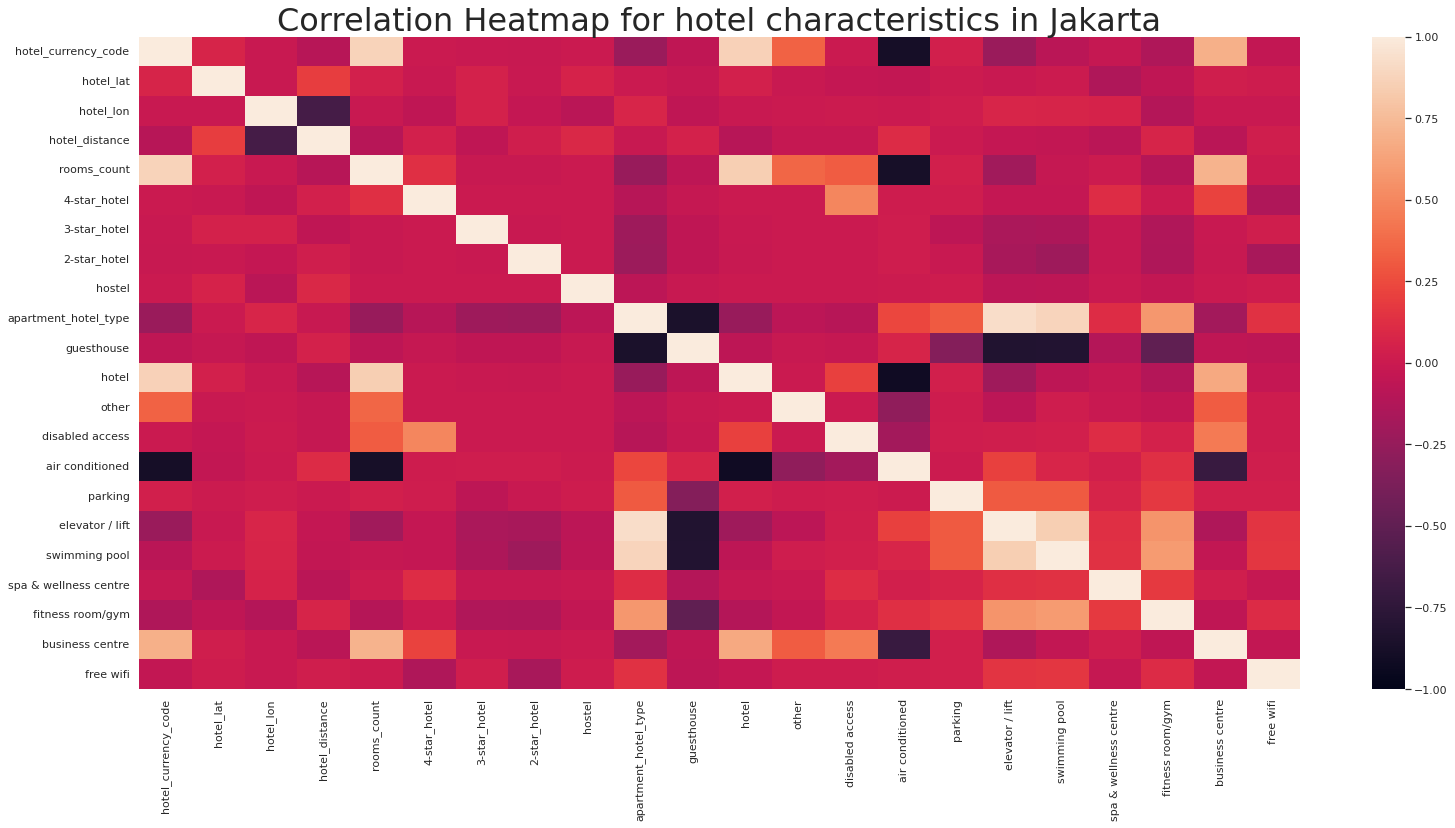

In [32]:

plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 36})
heatmap = sns.heatmap(indonesia.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in Jakarta", fontdict={"fontsize":32})

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in London')

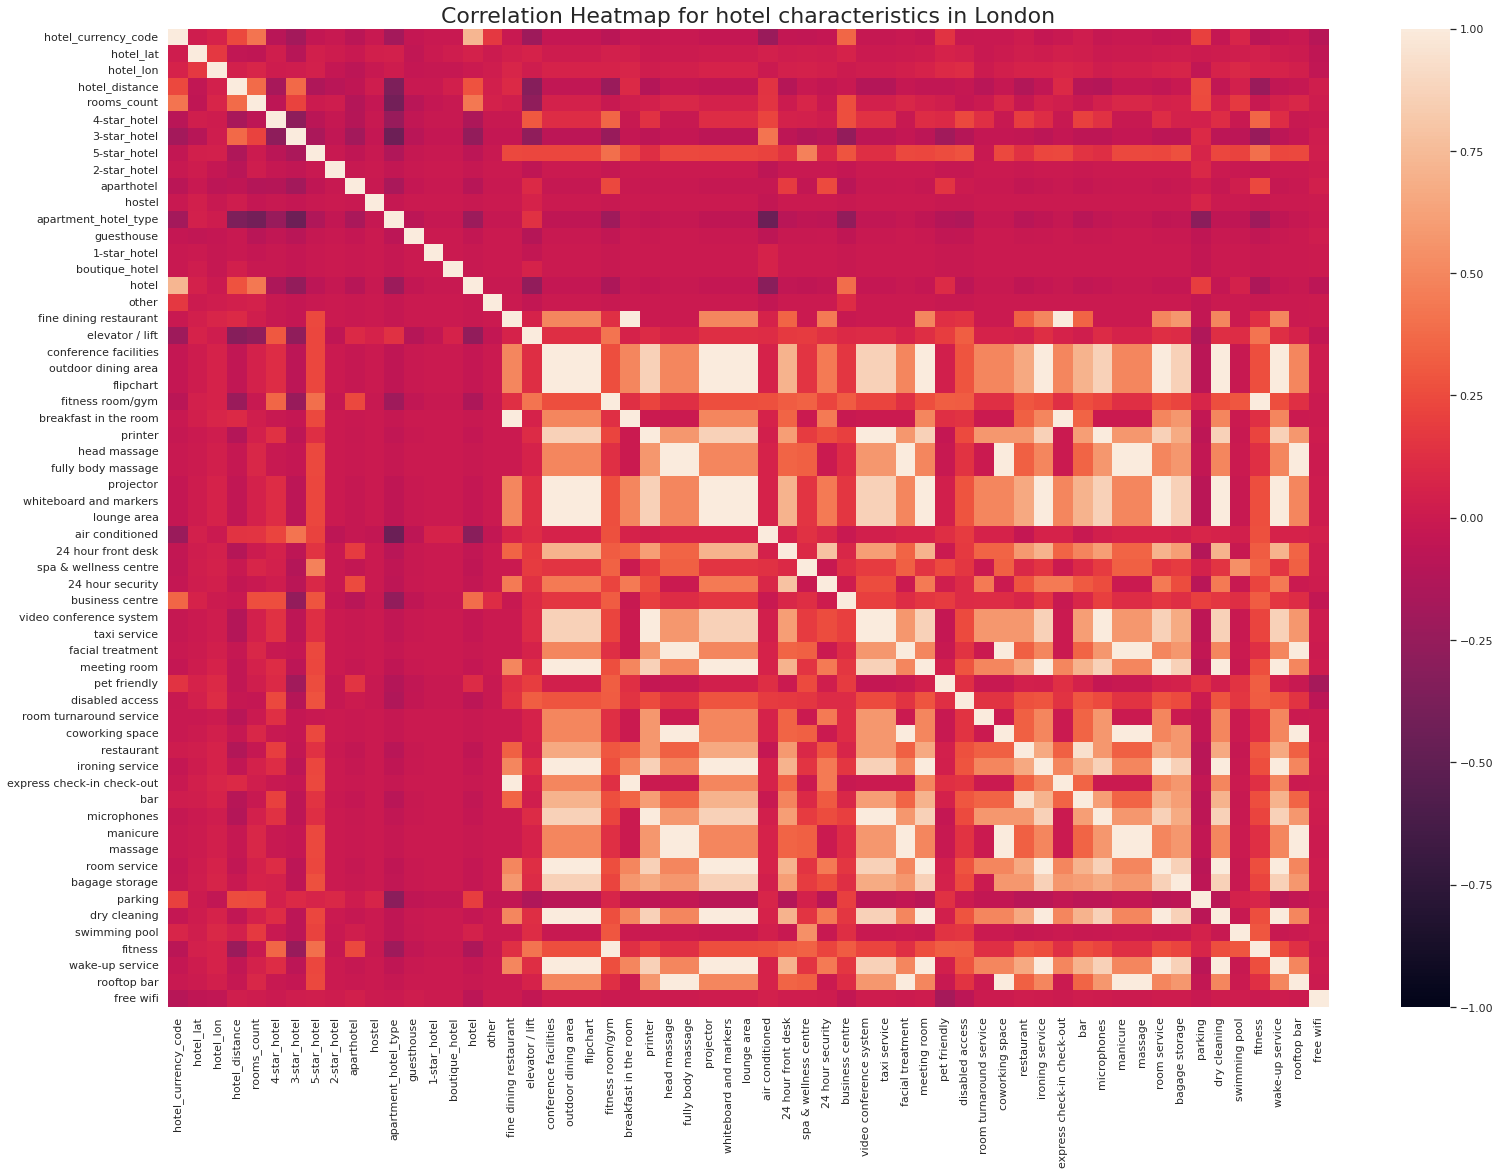

In [33]:

plt.figure(figsize=(26, 18))
plt.rcParams.update({'font.size': 22})
heatmap = sns.heatmap(gb.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in London", fontdict={"fontsize":22})

### <br> Concusions: 
#### this time I showed the correlaton between amenities separately for each city:
#### - both cities shows different amount of amenities available in given hotels;
#### - most of amenities are highly correlated for London, so they are showing the same segment of characteristics;
#### - the same pairs of amenities showed slightly different level of correlation for Jakarta and London but the trend was similar for both cities<br>


## Data Reduction

#### <br> **calc_vif** - a function that detects strong correlation and returns list of characteristics that should be removed. Here in the function they are listed to ne removed only these characteristics for which the VIF score was higher than 5.
#### **reduce_dimensions_by_pca** -a function that will be reducing dimentions if in the final dataset there will still be a lot of variables. <br>

In [34]:
def calc_vif(df):
    # Multicollinearity detection
    # df - dataFrame
    # col_names - names of columns you would like to calculate the VIF score   
    vif = pd.DataFrame()

    variables = df
    df_vif = add_constant(variables)
    vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif["variables"] = df_vif.columns
    vif["VIF"].replace([np.inf, -np.inf], np.nan, inplace=True)
    vifToReduce = vif.loc[(vif["VIF"].isnull())]
    return vifToReduce["variables"].tolist()

def select_variables(df, col_names):
    # returning the 
    if "const" in col_names:       
        const_to_remove = col_names.index("const")
        del col_names[const_to_remove]

    df_selected_variables = df
    df_selected_variables.drop(columns=col_names, inplace=True)

    return df_selected_variables

In [35]:
gbToReduce = calc_vif(gb)
idToReduce = calc_vif(indonesia)

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


#### <br> Removing from the working file variables which are highly correlated <br>

In [36]:
idReduced = select_variables(filesWorkingIDCleaned, idToReduce)
gbReduced = select_variables(filesWorkingGBCleaned, gbToReduce)

#### Creating copy that is not containing Hotel id for the analysis

In [37]:
idReducedAnalysis = idReduced.drop(columns=["hotel_id"])
gbReducedAnalysis = gbReduced.drop(columns=["hotel_id"])

In [38]:
#### ploting correlation heatmap for final hotel characteristics

(648, 14)

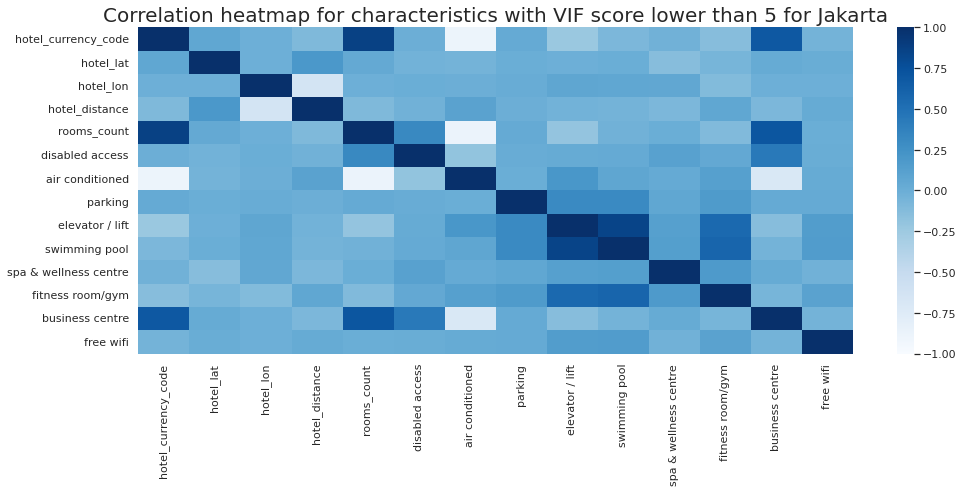

In [39]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(idReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for Jakarta", fontsize=20)
idReducedAnalysis.shape

(390, 14)

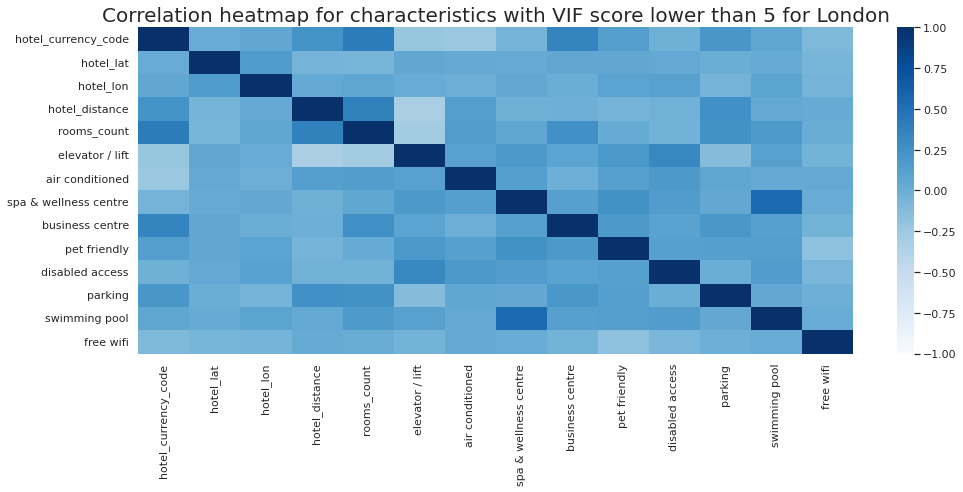

In [40]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(gbReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for London", fontsize=20)
gbReducedAnalysis.shape

### <br> Conclusions:
#### - this time  function detecting multcolinearity was removing characteristics VIF score higher that 5 what was recomended by documantation, it reduced the dimentions to 9 for Jakarta, 14 for London and 11 for cumulative dataset.
#### - such restrict removing  <br>


## <br>Standarizing data
#### <br> to standarize the data was used Standard Scaler provided by sklear library<br>

In [41]:
scaler = StandardScaler()
# standarizing data from Jakarta
indo_std = scaler.fit_transform(idReducedAnalysis)
# standarizing data from London
gb_std = scaler.fit_transform(gbReducedAnalysis)

## <br> Removing Dimentions
####  <br> This time I used first PCA and then UMAP to reduce dimentionality of the provided data. <br>

#### PCA for Jakarta

In [42]:
pca_indoesia = PCA(n_components=0.95)
train_pca_indonesia = pca_indoesia.fit_transform(indo_std)
train_pca_indonesia[:1]

array([[ 7.77028106,  6.93326992,  0.08795564, 13.20461905,  9.37819698,
         6.65638726,  2.89985249, -0.07866691,  0.20816832, -0.32936202]])

In [43]:
pca_indoesia.n_components_

10

#### UMAP for Jakarta

In [44]:
clusterable_embedding_indo = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(train_pca_indonesia)

clusterable_embedding_indo

array([[ 8.934825 , 15.341394 ],
       [ 7.265649 , -3.3212802],
       [-5.6981716, -7.391293 ],
       ...,
       [ 9.835663 , -5.1164575],
       [ 9.808166 , -5.1445813],
       [ 9.792248 , -5.1606073]], dtype=float32)

In [45]:
indonesia_train_umap_df = pd.DataFrame(data=np.c_[clusterable_embedding_indo], columns = ["umap_1", "umap_2"])
indonesia_train_umap_df

umap_1     umap_2
0     8.934825  15.341394
1     7.265649  -3.321280
2    -5.698172  -7.391293
3    13.002372  19.411013
4     2.672396   5.964492
..         ...        ...
643   9.847898  -5.105077
644   9.798828  -5.154037
645   9.835663  -5.116457
646   9.808166  -5.144581
647   9.792248  -5.160607

[648 rows x 2 columns]

#### PCA for London

In [48]:
pca_gb = PCA(n_components=0.95)
train_pca_gb = pca_gb.fit_transform(gb_std)
train_pca_gb[:1]

array([[-1.37105304,  0.74641921, -0.33607842,  0.35802653, -0.19647635,
        -0.39581784, -0.19159181,  0.08512098, -0.90633081, -0.07965769,
         0.42555749,  0.75676824, -0.12575498]])

In [49]:
pca_gb.n_components_

13

#### UMAP for London

In [50]:
clusterable_embedding_gb = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(train_pca_gb)
clusterable_embedding_gb

array([[-7.20893192e+00,  2.08154488e+00],
       [ 9.37312317e+00,  1.68031902e+01],
       [ 1.18654280e+01,  4.53707075e+00],
       [-7.14322567e+00,  2.22194576e+00],
       [ 1.18247662e+01,  4.46957064e+00],
       [ 8.28985119e+00,  1.49605389e+01],
       [ 1.35528450e+01,  4.48135185e+00],
       [ 7.94268179e+00, -4.53485346e+00],
       [ 1.28040619e+01,  4.56414652e+00],
       [ 1.28208466e+01,  4.57077217e+00],
       [ 5.42138433e+00,  2.85513949e+00],
       [ 7.94423628e+00, -4.55802345e+00],
       [ 1.19396887e+01,  4.53418207e+00],
       [ 1.00480862e+01,  3.74238968e+00],
       [ 1.20105362e+01,  1.57685537e+01],
       [ 1.07846022e+01,  4.59998798e+00],
       [ 1.05747509e+01,  4.73718834e+00],
       [ 9.40321064e+00,  1.68111362e+01],
       [ 6.02786541e+00,  7.37352848e-01],
       [ 1.06945629e+01,  4.79606819e+00],
       [ 1.28815956e+01,  4.54184580e+00],
       [ 1.29190941e+01,  4.51373482e+00],
       [ 5.52391052e+00,  2.73346734e+00],
       [-6.

In [51]:
gb_train_umap_df = pd.DataFrame(data=np.c_[clusterable_embedding_gb], columns = ["umap_1", "umap_2"])
gb_train_umap_df

umap_1     umap_2
0    -7.208932   2.081545
1     9.373123  16.803190
2    11.865428   4.537071
3    -7.143226   2.221946
4    11.824766   4.469571
..         ...        ...
385  15.306011   4.094600
386  11.801499   4.458329
387  10.854175   3.113807
388   8.792769   5.035425
389   6.247767   0.930204

[390 rows x 2 columns]

## <br> HDBSCAN Clustering analysis<br>

## <br>There were performed 2 analysis:
#### 1. for Jakarta
#### 2. for London<br>

### <br> 1. Jakarta <br>
#### min_cluster_size was found checking different value and taking into consideration these values that have the greatest **DBCV - Denstity Based Clustering Validation** <br>

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

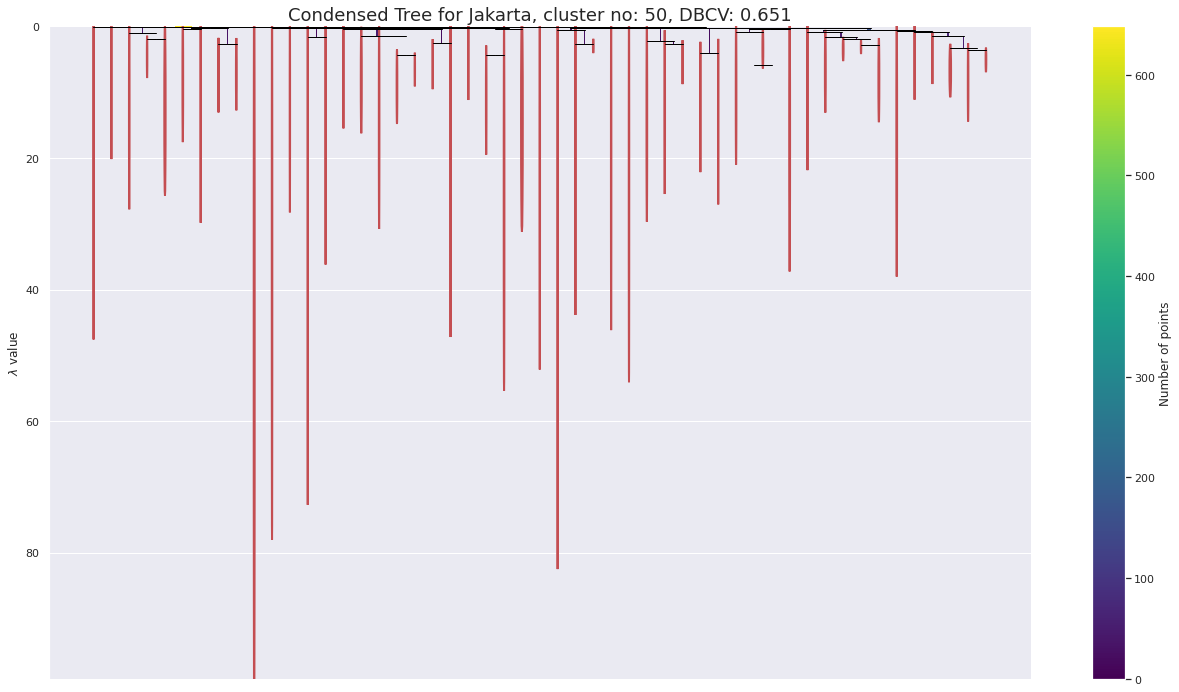

In [58]:
plt.figure(figsize=(22, 12))
plt.title("Condensed Tree for Jakarta, cluster no: 50, DBCV: 0.651", fontdict={"fontsize":18})
hdbscan_indo1 = hdbscan.HDBSCAN(min_cluster_size=6)
labels1 = hdbscan_indo1.fit_predict(clusterable_embedding_indo)
hdbscan_indo1.condensed_tree_.plot(select_clusters=True)
np.unique(labels1)


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40])

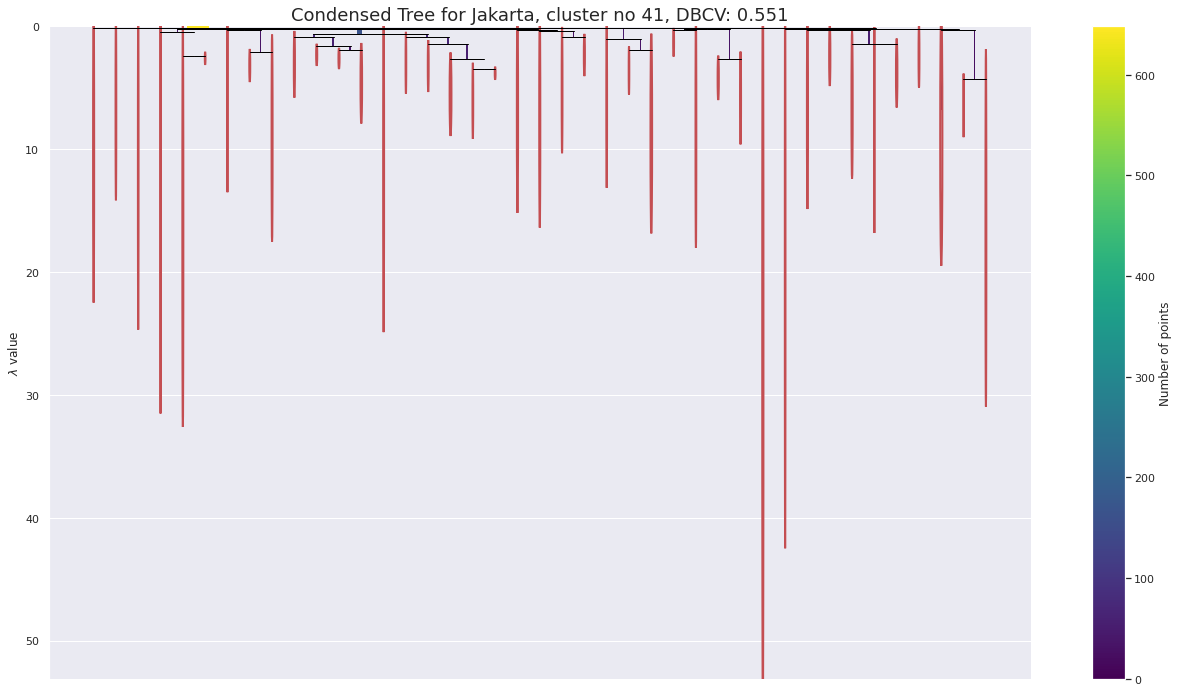

In [59]:
plt.figure(figsize=(22, 12))
plt.title("Condensed Tree for Jakarta, cluster no 41, DBCV: 0.551", fontdict={"fontsize":18})
hdbscan_indo2 = hdbscan.HDBSCAN(min_cluster_size=8)
labels2 = hdbscan_indo2.fit_predict(clusterable_embedding_indo)
hdbscan_indo2.condensed_tree_.plot(select_clusters=True)
np.unique(labels2)

### <br> Summary of general statistics for Jakarta clusters <br>
#### To assess the quality of produced clusters there a few metrics that can be used. Below I calculate the total number of clusters and total number of noice¶
#### which in other words mean that number of points that where not attached to any cluster. <br>

In [60]:
n1_clusters_ = len(set(labels1[:])) - (1 if -1 in labels1[:] else 0)
n1_noise_ = list(labels1[:]).count(-1)
n2_clusters_ = len(set(labels2[:])) - (1 if -1 in labels2[:] else 0)
n2_noise_ = list(labels2[:]).count(-1)

#### <br>**DBCV - Density Based Clustering Validation** computes two values:

####   - the density within a cluster
####   - the density between clusters
#### High density within a cluster, and low density between clusters indicates good clustering assignments.<br>



In [55]:
hdbscan_score1 = DBCV(clusterable_embedding_indo, labels1, dist_function=euclidean)
hdbscan_score2 = DBCV(clusterable_embedding_indo, labels2, dist_function=euclidean)

In [61]:
print("SUMMARY FOR JAKARTA")
print()
print("Estimation 1: number of clusters: %d" % n1_clusters_)
print("Estimation 1: number of noise points: %d" % n1_noise_)
print("Estimation 1: DBCV: %0.3f" % hdbscan_score1)
print()
print("Estimation 2: number of clusters: %d" % n2_clusters_)
print("Estimation 2: number of noise points: %d" % n2_noise_)
print("Estimation 2: DBCV: %0.3f" % hdbscan_score2)

SUMMARY FOR JAKARTA

Estimation 1: number of clusters: 50
Estimation 1: number of noise points: 2
Estimation 1: DBCV: 0.651

Estimation 2: number of clusters: 41
Estimation 2: number of noise points: 35
Estimation 2: DBCV: 0.551


In [62]:
idReduced["cluster1"] = labels1
idReduced["cluster2"] = labels2

In [63]:
idReduced

hotel_id  hotel_currency_code  hotel_lat   hotel_lon  hotel_distance  \
0       52765                    1   -6.25534  106.810825        6.180000   
1      506274                    1   -6.17542  106.729023       13.450000   
2      506275                    1   -6.20835  106.818008        3.020000   
3      506278                    1   -6.22346  106.784432        6.840000   
4      506279                    1   -6.16237  106.832172        5.650000   
..        ...                  ...        ...         ...             ...   
643    589802                    2   -6.22141  106.815778        3.931276   
644    589803                    3   -6.12715  106.790440        3.931276   
645    589804                    2   -6.26462  106.782179        3.931276   
646    589805                    3   -6.18720  106.821936        3.931276   
647    589810                    3   -6.14123  106.853436        3.931276   

     rooms_count  disabled access  air conditioned  parking  elevator / lift  \
0            203                1                1        1                1   
1              1                0                1        1                1   
2              1                0                1        1                1   
3              1                0                1        1                1   
4              1                0                1        1                1   
..           ...              ...              ...      ...              ...   
643          214                0                0        1                0   
644          300                0                0        1                0   
645          311                0                0        1                0   
646          222                0                0        1                0   
647          272                0                0        1                0   

     swimming pool  spa & wellness centre  fitness room/gym  business centre  \
0                1                      1                 1                1   
1                1                      0                 1                0   
2                1                      0                 0                0   
3                1                      0                 1                0   
4                1                      0                 0                0   
..             ...                    ...               ...              ...   
643              1                      0                 0                0   
644              0                      0                 0                1   
645              1                      0                 0                1   
646              0                      0                 0                1   
647              1                      0                 0                1   

     free wifi  cluster1  cluster2  
0            1        27        36  
1            1         7         9  
2            1         1         1  
3            1        14        -1  
4            1        43        29  
..         ...       ...       ...  
643          1         8        10  
644          1         8        10  
645          1         8        10  
646          1         8        10  
647          1         8        10  

[648 rows x 17 columns]

In [64]:
indonesia_train_umap_df["cluster1"] = labels1
indonesia_train_umap_df["cluster2"] = labels2
indonesia_train_umap_df

umap_1     umap_2  cluster1  cluster2
0     8.934825  15.341394        27        36
1     7.265649  -3.321280         7         9
2    -5.698172  -7.391293         1         1
3    13.002372  19.411013        14        -1
4     2.672396   5.964492        43        29
..         ...        ...       ...       ...
643   9.847898  -5.105077         8        10
644   9.798828  -5.154037         8        10
645   9.835663  -5.116457         8        10
646   9.808166  -5.144581         8        10
647   9.792248  -5.160607         8        10

[648 rows x 4 columns]

### Visualizing clusters for Jakarta

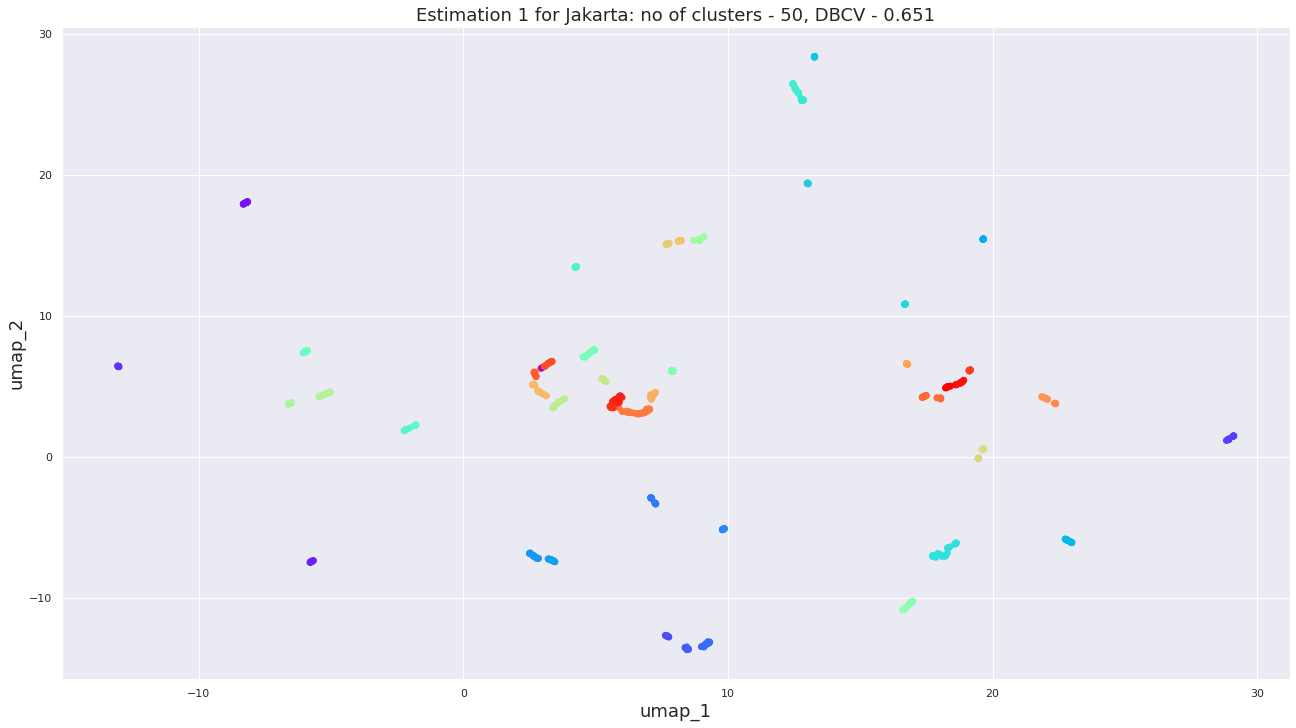

In [69]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=indonesia_train_umap_df, x="umap_1", y="umap_2", c= "cluster1", cmap = "rainbow", label = "cluster1")
plt.xlabel("umap_1",**axis_font)
plt.ylabel("umap_2",**axis_font)
plt.title("Estimation 1 for Jakarta: no of clusters - 50, DBCV - 0.651", fontdict={"fontsize":18})
plt.show()

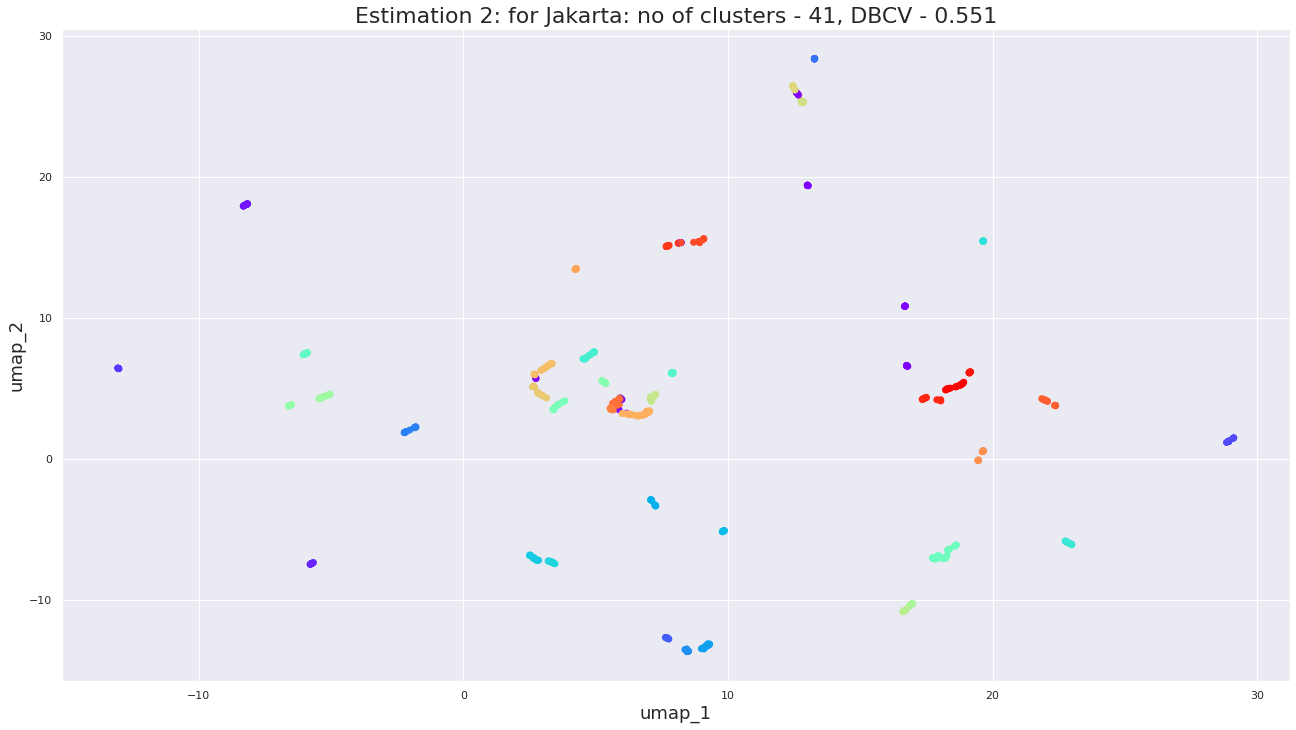

In [70]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=indonesia_train_umap_df, x="umap_1", y="umap_2", c= "cluster2", cmap = "rainbow", label = "cluster2")
plt.xlabel("umap_1",**axis_font)
plt.ylabel("umap_2",**axis_font)
plt.title("Estimation 2: for Jakarta: no of clusters - 41, DBCV - 0.551", fontdict={"fontsize":22})
plt.show()

In [71]:
# visualizing the plot in plotly
px.scatter(indonesia_train_umap_df, x="umap_1", y="umap_2", color = "cluster1",  template = "plotly_dark", title = "Estimation 1 for Jakarta: no of clusters - 50, DBCV - 0.611")

In [72]:
px.scatter(indonesia_train_umap_df, x="umap_1", y="umap_2", color = "cluster2",  template = "plotly_dark", title = "Estimation 2: for Jakarta: no of clusters - 41, DBCV - 0.551")

### 2. London

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36])

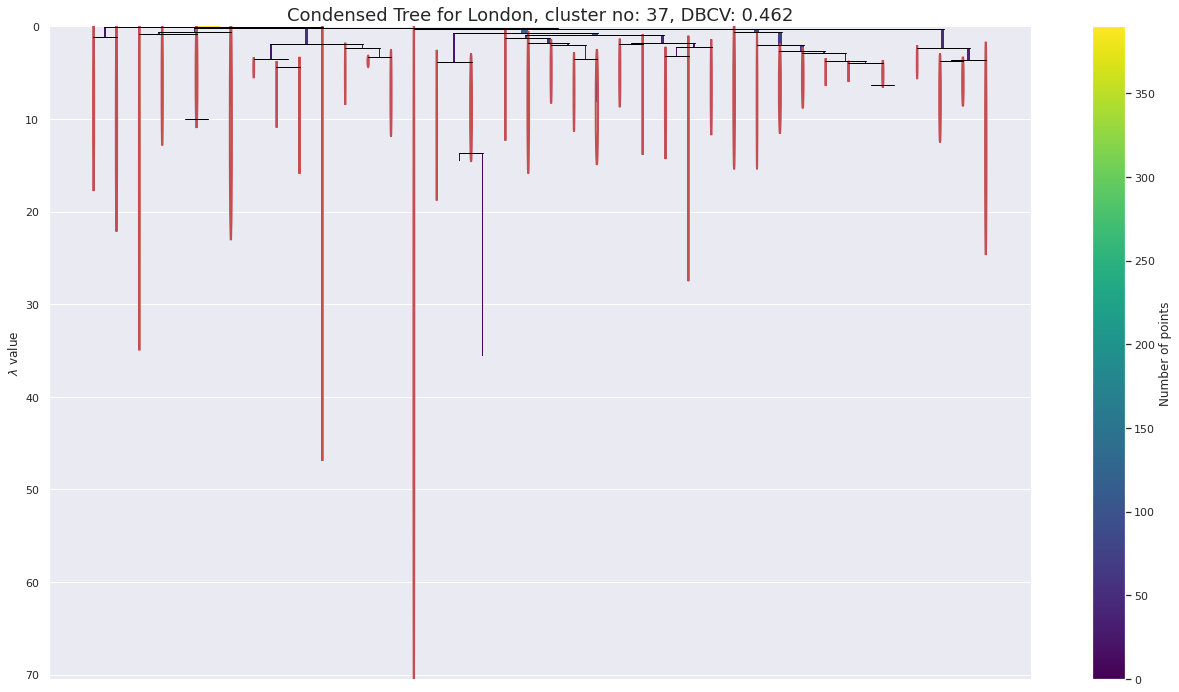

In [78]:
plt.figure(figsize=(22, 12))
plt.title("Condensed Tree for London, cluster no: 37, DBCV: 0.462", fontdict={"fontsize":18})
hdbscan_indo1 = hdbscan.HDBSCAN(min_cluster_size=4)
labels1 = hdbscan_indo1.fit_predict(clusterable_embedding_gb)
hdbscan_indo1.condensed_tree_.plot(select_clusters=True)
np.unique(labels1)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

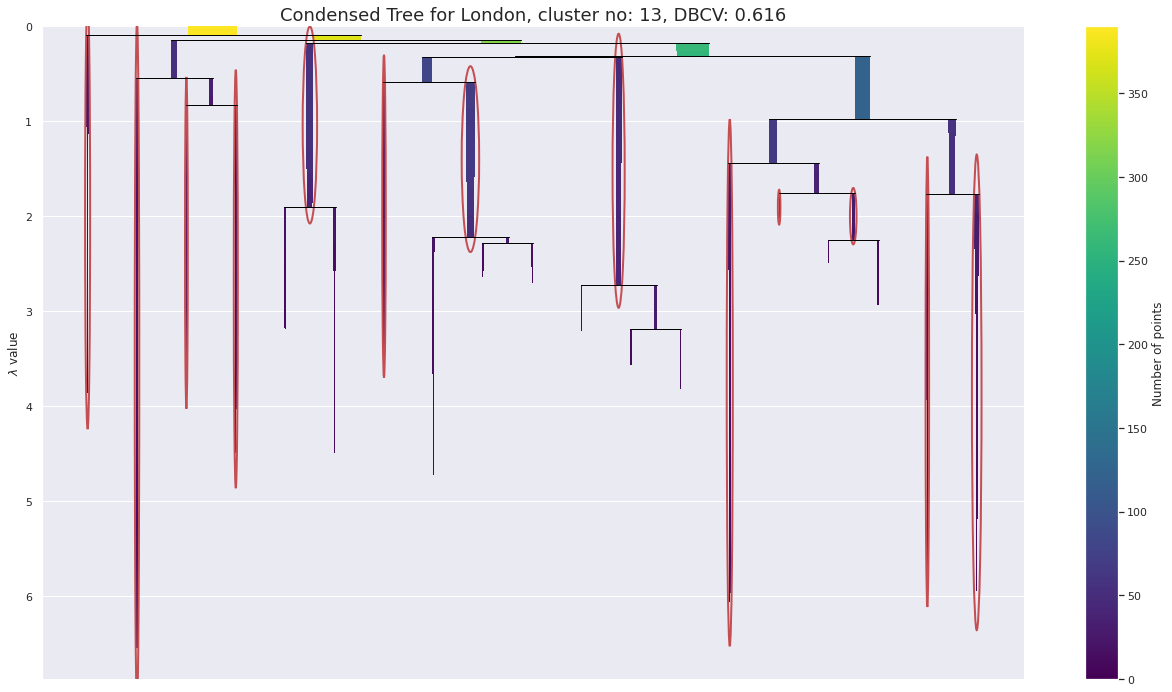

In [79]:
plt.figure(figsize=(22, 12))
plt.title("Condensed Tree for London, cluster no: 13, DBCV: 0.616", fontdict={"fontsize":18})
hdbscan_indo2 = hdbscan.HDBSCAN(min_cluster_size=9)
labels2 = hdbscan_indo2.fit_predict(clusterable_embedding_gb)
hdbscan_indo2.condensed_tree_.plot(select_clusters=True)
np.unique(labels2)

### <br> Summary of general statistics for London clusters <br>

In [80]:
n1_clusters_ = len(set(labels1[:])) - (1 if -1 in labels1[:] else 0)
n1_noise_ = list(labels1[:]).count(-1)
n2_clusters_ = len(set(labels2[:])) - (1 if -1 in labels2[:] else 0)
n2_noise_ = list(labels2[:]).count(-1)

In [76]:
hdbscan_score1 = DBCV(clusterable_embedding_gb, labels1, dist_function=euclidean)
hdbscan_score2 = DBCV(clusterable_embedding_gb, labels2, dist_function=euclidean)

In [81]:
print("SUMARY FOR LONDON")
print()
print("Estimation 1: number of clusters: %d" % n1_clusters_)
print("Estimation 1: number of noise points: %d" % n1_noise_)
print("Estimation 1: DBCV: %0.3f" % hdbscan_score1)
print()
print("Estimation 2: number of clusters: %d" % n2_clusters_)
print("Estimation 2: number of noise points: %d" % n2_noise_)
print("Estimation 2: DBCV: %0.3f" % hdbscan_score2)

SUMARY FOR LONDON

Estimation 1: number of clusters: 37
Estimation 1: number of noise points: 20
Estimation 1: DBCV: 0.462

Estimation 2: number of clusters: 13
Estimation 2: number of noise points: 25
Estimation 2: DBCV: 0.616


In [82]:
gbReduced["cluster1"] = labels1
gbReduced["cluster2"] = labels2

In [83]:
gbReduced

hotel_id  hotel_currency_code  hotel_lat  hotel_lon  hotel_distance  \
0        5622                    1  51.521259   -0.15586        3.120000   
1        5630                    1  51.512071   -0.18521        4.300000   
2        5640                    1  51.507706   -0.14714        1.670000   
3        5671                    1  51.490098   -0.13813        1.390000   
4        5681                    1  51.496872   -0.16760        2.890000   
..        ...                  ...        ...        ...             ...   
385    589981                    3  51.508232    0.04376        6.915566   
386    590977                    1  51.516015   -0.11857        1.840000   
387    592390                    1  51.543948   -0.15233        5.200000   
388    592405                    1  51.511208   -0.11935        1.320000   
389    592406                    1  51.506490   -0.07172        3.840000   

     rooms_count  elevator / lift  air conditioned  spa & wellness centre  \
0             34                1                1                      0   
1             45                1                0                      0   
2            106                1                0                      0   
3             72                1                1                      0   
4             28                1                0                      0   
..           ...              ...              ...                    ...   
385          225                0                0                      0   
386            0                1                1                      0   
387            1                0                0                      0   
388            0                0                0                      0   
389            0                0                0                      0   

     business centre  pet friendly  disabled access  parking  swimming pool  \
0                  0             0                0        0              0   
1                  0             0                0        0              0   
2                  1             1                0        1              0   
3                  0             0                0        0              0   
4                  1             1                0        1              0   
..               ...           ...              ...      ...            ...   
385                0             0                0        1              0   
386                1             1                0        1              0   
387                0             1                0        0              0   
388                0             0                1        0              0   
389                0             0                0        1              0   

     free wifi  cluster1  cluster2  
0            1         0         0  
1            1         6         4  
2            1        14        -1  
3            1         0         0  
4            1        14        -1  
..         ...       ...       ...  
385          1        28        12  
386          1        14        -1  
387          1        25        10  
388          1        22         8  
389          1        32         7  

[390 rows x 17 columns]

In [84]:
gb_train_umap_df["cluster1"] = labels1
gb_train_umap_df["cluster2"] = labels2
gb_train_umap_df

umap_1     umap_2  cluster1  cluster2
0    -7.208932   2.081545         0         0
1     9.373123  16.803190         6         4
2    11.865428   4.537071        14        -1
3    -7.143226   2.221946         0         0
4    11.824766   4.469571        14        -1
..         ...        ...       ...       ...
385  15.306011   4.094600        28        12
386  11.801499   4.458329        14        -1
387  10.854175   3.113807        25        10
388   8.792769   5.035425        22         8
389   6.247767   0.930204        32         7

[390 rows x 4 columns]

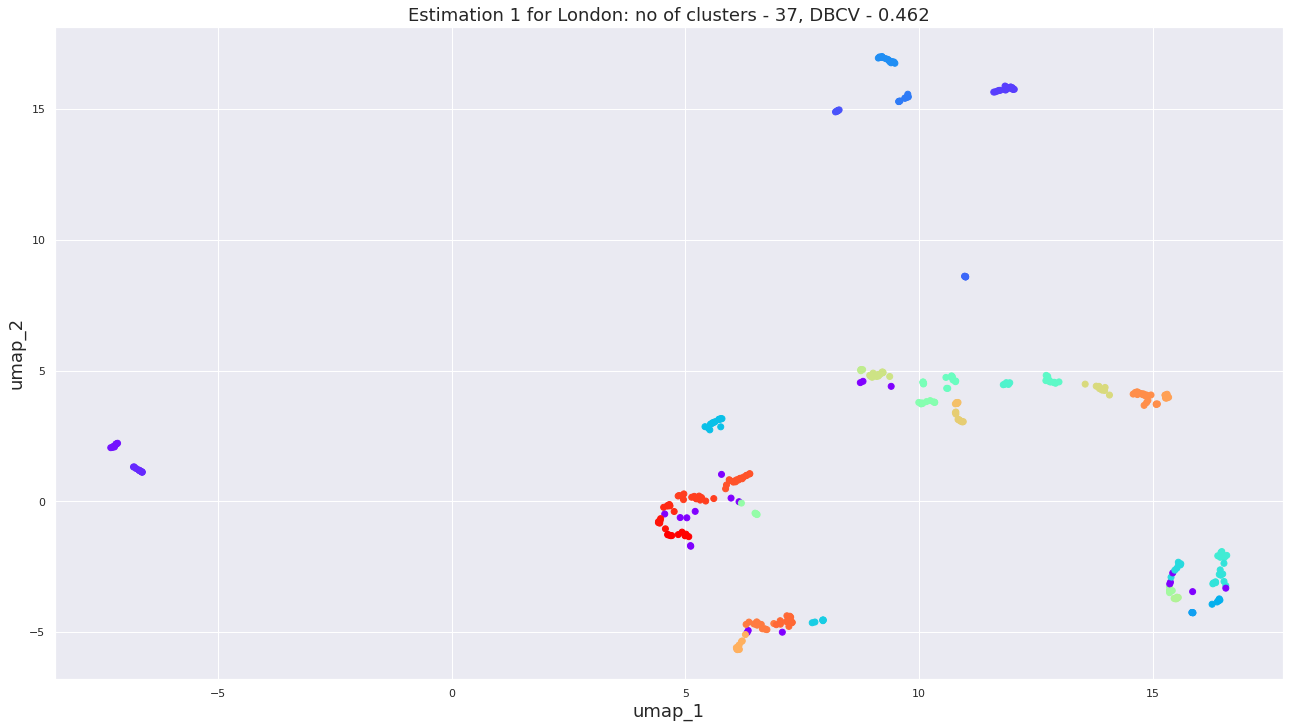

In [85]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=gb_train_umap_df, x="umap_1", y="umap_2", c= "cluster1", cmap = "rainbow", label = "cluster1")
plt.xlabel("umap_1",**axis_font)
plt.ylabel("umap_2",**axis_font)
plt.title("Estimation 1 for London: no of clusters - 37, DBCV - 0.462", fontdict={"fontsize":18})
plt.show()

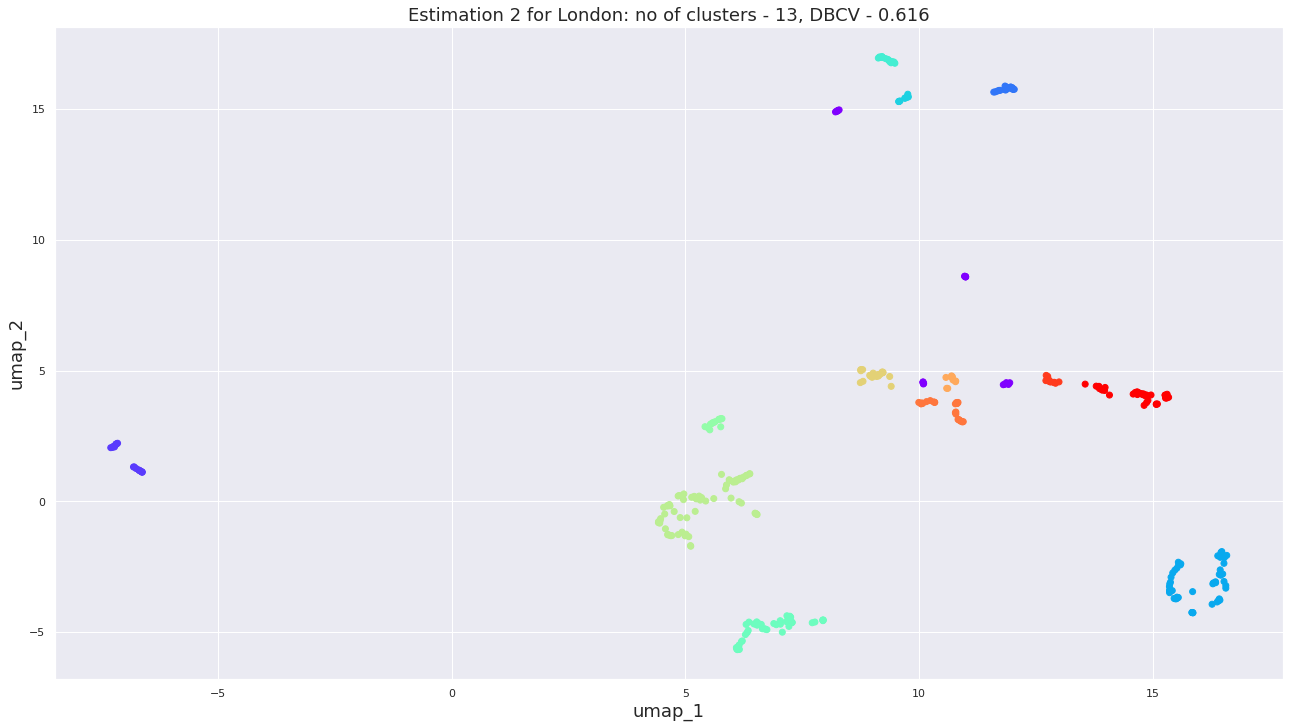

In [86]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=gb_train_umap_df, x="umap_1", y="umap_2", c= "cluster2", cmap = "rainbow", label = "cluster2")
plt.xlabel("umap_1",**axis_font)
plt.ylabel("umap_2",**axis_font)
plt.title("Estimation 2 for London: no of clusters - 13, DBCV - 0.616", fontdict={"fontsize":18})
plt.show()

In [87]:
#visualizing data also with plotly express
import plotly.express as px
px.scatter(gb_train_umap_df, x="umap_1", y="umap_2", color = "cluster1",  template = "plotly_dark", title = "Estimation 1 for London no of clusters - 37, DBCV - 0.462")

In [88]:
import plotly.express as px
px.scatter(gb_train_umap_df, x="umap_1", y="umap_2", color = "cluster2",  template = "plotly_dark", title = "Estimation 2 for London: no of clusters - 13, DBCV - 0.616")

## <br> Concusions:<br>
#### 1. HDBSCAN analysis for these 2 types of datasets with combination of PCA and UMAP algorythms as a dimention reduction algorythms created 50/41 clusters for Jakarta where different hotel types were 12, 37/13 for London where different hotel types were 18 with higher DBCV scores comparying to the ones created when only UMAP was used as a dimention reduction agorythm;
#### 2. Doing the analysis for mixed data is challenging, in most situations I was removing categorical data - that is why I do not processed together Jakarta and London this time as the cities ID were large numbers which could be wrongly interpreted by Standard Scaler <br>

In [89]:
with pd.ExcelWriter("Downloads/hdbscanPcaUMAPsamples.xlsx") as writer:
    idReduced.to_excel(writer, sheet_name="Jakarta")
    gbReduced.to_excel(writer, sheet_name="London")